# CV project

## import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from skimage.metrics import structural_similarity as ssim
from google.colab.patches import cv2_imshow

## functions

In [ ]:
def predict(model,images):
  y_pred = model.predict(images)
  number = ""
  for i in range(len(images)):
    sample_lbl = np.argmax(y_pred[i])
    number += str(sample_lbl)
  return number

In [40]:
def predict_card(path):
  card_path = crop_image(path)
  ss_card_path = crop_image_ss(path)

  final_path = ''

  if ss_card_path is not None:
    final_path = ss_card_path

  elif card_path is not None:
    final_path = card_path

  else:
    final_path = path

  type_card = detect_card(final_path)

  if type_card == 'credit card':
    print("Credit Card")
    cc_16_digots = find_cc_numbers_place(final_path)
    print(predict_cc_numbers(cc_16_digots))
  else:
    print("National Card")
    national_10_digits = find_national_numbers(final_path)
    print(predictNationalNumber(national_10_digits))

1/1 [==============================] - 0s 182ms/step
National Card


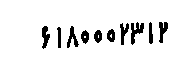

1/1 [==============================] - 0s 64ms/step
3323333332


In [50]:
path = '/content/drive/MyDrive/CV_Project2_OCR/results/ss/img24.jpg'
predict_card(path)

In [3]:
def imshow(im):
    width, height, *channels = im.shape
    if channels:
        # By default, OpenCV tends to work with images in the BGR format.
        # This is due to some outdated practices, but it has been left in the library.
        # We can iterate the channels in reverse order to get an RGB image.
        plt.imshow(im[:,:,::-1])
    else:
        plt.imshow(im, cmap='gray')
    plt.axis('off')

In [2]:
def sort_points_clockwise(points):
    # Calculate the centroid of the points
    centroid = np.mean(points, axis=0)
    # Sort the points based on their angle with respect to the centroid
    sorted_points = sorted(points, key=lambda p: np.arctan2(p[0][1] - centroid[0][1], p[0][0] - centroid[0][0]))
    return sorted_points

In [3]:
def standardize(x):
    x = np.array(x, dtype='float64')
    x -= np.min(x)
    x /= np.percentile(x, 98)
    x[x > 1] = 1
    return x

def preprocessing(img):
    image = np.array(img)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.zeros_like(image)
    image[:,:,0] = gray
    image[:,:,1] = gray
    image[:,:,2] = gray
    image = standardize(image)
    return image

In [4]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [7]:
model = tf.keras.models.load_model('/content/drive/MyDrive/CV_Project2_OCR/card')

# Part a - Pretrain code

## YOLO approach

In [ ]:
import os
import math
import torch
from urllib.request import urlopen
from skimage.metrics import structural_similarity as ssim
from models.experimental import attempt_load
from utils.general import check_img_size, non_max_suppression, scale_coords
from utils.torch_utils import select_device, TracedModel
from utils.datasets import letterbox

### clone the YOLOv7 github repository

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/augmentedstartups/yolov7.git
%cd yolov7
!pip install -r requirements.txt
!pip install roboflow

/content/drive/MyDrive
fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/drive/MyDrive/yolov7
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflic

### import the credit and national card dataset(this dataset create with roboflow site and with own data)

In [ ]:
%cd /content/drive/MyDrive/yolov7

from roboflow import Roboflow
rf = Roboflow(api_key="pgvneJK6LcPUKI4LqxmC")
project = rf.workspace("fcvproject").project("fcv_final_project")
dataset = project.version(5).download("yolov7")

### get the pre-trained YOLOv7 model and save the desired path in drive

In [ ]:
%%bash
!wget -P /content/drive/MyDrive/yolov7 https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt

### train the card data-set with pre-trained YOLOv7 model in 100 epochs

In [ ]:
!python train.py --batch 16 --cfg cfg/training/yolov7.yaml --epochs 100 --data /content/drive/MyDrive/yolov7/FCV_final_project-5/data.yaml --weights 'yolov7.pt' --device 0

In [ ]:
%cd /content/drive/MyDrive/yolov7

weights = 'runs/train/exp2/weights/best.pt'
device_id = 'cpu'
image_size = 640
trace = True

# Initialize
device = select_device(device_id)
half = device.type != 'cpu'  # half precision only supported on CUDA

# Load model
model = attempt_load(weights, map_location=device)  # load FP32 model
stride = int(model.stride.max())  # model stride
imgsz = check_img_size(image_size, s=stride)  # check img_size

if trace:
    model = TracedModel(model, device, image_size)

if half:
    model.half()  # to FP16
    model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once

/content/drive/MyDrive/yolov7
Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 



In [ ]:
img_size = 640
stride = 32

def find_cords(img_path):
  classes = ['ball', 'card', 'hand', 'card']
  img = cv2.imread(img_path)

  source_image = img
  img = letterbox(source_image, img_size, stride=stride)[0]

  img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
  img = np.ascontiguousarray(img)
  img = torch.from_numpy(img).to(device)
  img = img.half() if half else img.float()  # uint8 to fp16/32
  img /= 255.0  # 0 - 255 to 0.0 - 1.0
  if img.ndimension() == 3:
      img = img.unsqueeze(0)

  with torch.no_grad():
      # Inference
      pred = model(img, augment=True)[0]

  # Apply NMS
  pred = non_max_suppression(pred, 0.25, 0.45, classes=[0,1,2,3], agnostic=True)

  card_detections = []
  det_confidences = []
  classes_detection = []

  # Process detections
  for i, det in enumerate(pred):  # detections per image
      if len(det):
          # Rescale boxes from img_size to im0 size
          det[:, :4] = scale_coords(img.shape[2:], det[:, :4], source_image.shape).round()

          # Return results
          for *xyxy, conf, cls in reversed(det):
              coords = [int(position) for position in (torch.tensor(xyxy).view(1, 4)).tolist()[0]]
              card_detections.append(coords)
              det_confidences.append(conf.item())
              classes_detection.append(classes[int(cls)])

  return classes_detection, card_detections, source_image


In [ ]:
# your code here #
%cd /content/drive/MyDrive/yolov7

output_dir = 'Validation-images'
# Create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

images = ['https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051709_y_pgpumi.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979654/FCV_project/photo_5819152508638051682_y_hbugkz.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051699_y_d4j426.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979654/FCV_project/photo_5819152508638051681_y_sxlcyl.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979654/FCV_project/photo_5819152508638051679_y_qtkpxc.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051698_y_pjoyc8.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051708_y_pdcgmz.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051722_y_dr2wdi.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979653/FCV_project/photo_5819152508638051696_y_xop7q5.jpg',
          'https://res.cloudinary.com/dcumzaney/image/upload/v1687979437/FCV_project/photo_5819152508638051725_y_rie6tp.jpg']

req = urlopen(images[9])
img_name = os.path.basename(images[9])
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
img = cv2.imdecode(arr, cv2.IMREAD_COLOR)

image_path = os.path.join(output_dir, img_name)
cv2.imwrite(image_path, img)

!python detect.py --weights runs/train/exp2/weights/best.pt --conf 0.1 --source {image_path}

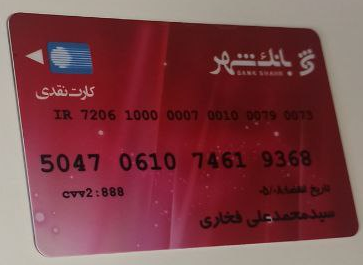

In [ ]:
from google.colab.patches import cv2_imshow
classes, cordinations, img = find_cords('/content/drive/MyDrive/CV_Project2_OCR/images/img5.jpg')

cord = []
for i, v in enumerate(classes):
  if v == 'card':
    cord = cordinations[i]

width = cord[2] - cord[0]
height = cord[3] - cord[1]
src_points = np.array([[cord[0], cord[1]], [cord[0]+width, cord[1]], [cord[0]+width, cord[1]+height], [cord[0], cord[1]+height]], dtype="float32")
dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")

M = cv2.getPerspectiveTransform(src_points, dst_points)
warped = cv2.warpPerspective(img, M, (int(width), int(height)))

cv2_imshow(warped)

## computer vision aproach for cutting images

### use the simple computer vision approach

In [30]:
def crop_image(img_path):
  org_img = cv2.imread(img_path)
  img = org_img.copy()
  img = cv2.fastNlMeansDenoising(img, h = 20)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 2)
  img = cv2.bitwise_not(img)
  kernel = cv2.getStructuringElement(
              cv2.MORPH_ELLIPSE,
              (17, 17)
          )

  close = cv2.morphologyEx(
              img,
              cv2.MORPH_CLOSE,
              kernel,
              iterations = 10
          )

  edged_img = cv2.Canny(close, 100, 100, 3)
  contours, _ = cv2.findContours(edged_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  max_perimeter = 0
  for cnt in contours:
    # Approximate the contour using a polygon
    p = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02*p, True)

    # Check if the polygon has four sides
    if len(approx) == 4:
        # Calculate the perimeter of the polygon
        perimeter = cv2.arcLength(cnt, True)

        # Find the corners of the rectangle using a more accurate value for epsilon
        epsilon = 0.1 * perimeter
        corners = cv2.approxPolyDP(cnt, epsilon, True)
        max_perimeter = p

  # cv2.drawContours(org_img, [corners], 0, (0, 0, 0), 2)
  try:
    src_points = corners.astype("float32")
    src_points = np.array(sort_points_clockwise(src_points)).astype("float32")
    width =  src_points[1][0][0] - src_points[0][0][0]
    height = src_points[3][0][1] - src_points[0][0][1]

    dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(org_img, M, (int(width), int(height)))

    # return warped
    return f'/content/drive/MyDrive/CV_Project2_OCR/results/{img_path.split("/")[-1]}'
    cv2.imwrite(f'/content/drive/MyDrive/CV_Project2_OCR/results/{img_path.split("/")[-1]}', warped)
  except:
    return None

In [31]:
def crop_image_ss(img_path):
  img = cv2.imread(path)
  org_img = img.copy()
  img = cv2.fastNlMeansDenoising(img, h = 20)
  h, w = img.shape[0:2]
  img = cv2.resize(img, (256, 256))
  img = preprocessing(img)

  pred = np.array(create_mask(model.predict(img[tf.newaxis, ...])))
  img3 = np.squeeze(pred)
  im = np.array(img3)
  cv2.imwrite('a.jpg', im)

  ss_img = cv2.imread('a.jpg')
  ss_img = cv2.resize(ss_img, (w, h))
  ss_img = np.where(ss_img > 0, 255, 0)

  ss_img = ss_img.astype(np.uint8)

  kernel = cv2.getStructuringElement(
              cv2.MORPH_ELLIPSE,
              (9, 9)
          )


  open = cv2.morphologyEx(
              ss_img,
              cv2.MORPH_OPEN,
              kernel,
              iterations = 5
          )

  edged_img = cv2.Canny(open, 100, 100, 3)

  contours, _ = cv2.findContours(edged_img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  hull = cv2.convexHull(max(contours, key=cv2.contourArea))
  epsilon = 0.1 * cv2.arcLength(hull, True)
  corners = cv2.approxPolyDP(hull, epsilon, True)

  try:
    src_points = corners.astype("float32")
    src_points = np.array(sort_points_clockwise(src_points)).astype("float32")
    width =  src_points[1][0][0] - src_points[0][0][0]
    height = src_points[3][0][1] - src_points[0][0][1]

    dst_points = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(org_img, M, (int(width), int(height)))

    cv2.drawContours(org_img, [hull], 0, (0, 255, 0), 3)

    # return warped
    return f'/content/drive/MyDrive/CV_Project2_OCR/results/ss/{img_path.split("/")[-1]}'
    cv2.imwrite(f'/content/drive/MyDrive/CV_Project2_OCR/results/ss/{img_path.split("/")[-1]}', warped)
  except:
    return None

In [ ]:
path = '/content/drive/MyDrive/CV_Project2_OCR/images/img16.jpg'
crop_image(path)
crop_image_ss(path)

1/1 [==============================] - 0s 157ms/step


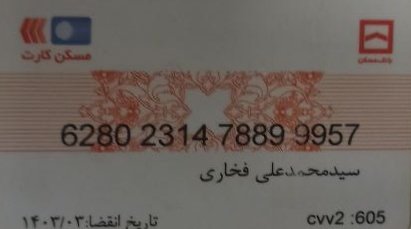

In [ ]:
path2 = '/content/drive/MyDrive/CV_Project2_OCR/results/img1.jpg'
path3 = '/content/drive/MyDrive/CV_Project2_OCR/results/ss/img16.jpg'
# res_img = cv2.imread(path2)
# cv2_imshow(res_img)

res_img2 = cv2.imread(path3)
cv2_imshow(res_img2)

### use the semantic segmentation approach

In [ ]:
images_path = "/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images"
masks_path = "/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/masks"


images_path2 = '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/IMAGES'
masks_path2 = '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/MASKS'

In [ ]:
OUTPUT_CHANNELS = 2
classes = {'background':0, 'card': 1}

In [ ]:
import os
#Capture training image info as a list
images_paths = []
masks_paths = []

images_paths2 = []
masks_paths2 = []

for imgname in os.listdir(images_path):
  images_paths.append(os.path.join(images_path,imgname))

for imgname in os.listdir(masks_path):
  masks_paths.append(os.path.join(masks_path,imgname))

for imgname in os.listdir(images_path2):
  images_paths2.append(os.path.join(images_path2,imgname))

for imgname in os.listdir(masks_path2):
  masks_paths2.append(os.path.join(masks_path2,imgname))

In [ ]:
images_paths.sort()
masks_paths.sort()

images_paths2.sort()
masks_paths2.sort()

In [ ]:
print(images_paths[100:110])
print(masks_paths[100:110])

['/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_11.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_12.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_13.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_14.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_15.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_16.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_17.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_18.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_19.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/CA04_20.jpg']
['/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/masks/CA04_11.png', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/

In [ ]:
print(images_paths2[10:15])
print(masks_paths2[10:15])

['/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/image13_jpg.rf.3dffbb07095ed2fc80cee5551f5b7df7.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/image13_jpg.rf.42291820e801a900e8a2141cb7a4830a.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/image14_jpg.rf.4c4fde55c1af8997dd8a4bf1e1641fba.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/image14_jpg.rf.5fccd90be507f71b1faaf974cf7d28dd.jpg', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/images/image14_jpg.rf.a246aa83e73ea8ca725339b1153abb66.jpg']
['/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/masks/image13_jpg.rf.3dffbb07095ed2fc80cee5551f5b7df7_mask.png', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/masks/image13_jpg.rf.42291820e801a900e8a2141cb7a4830a_mask.png', '/content/drive/MyDrive/CV_Project2_OCR/card-detection-semantic/masks/image14_jpg.rf.4c4fde55c1af8997dd8a4bf1e1641f

In [ ]:
from sklearn.model_selection import train_test_split

#Resizing images, if needed
SIZE_X = 256
SIZE_Y = 256
n_classes=2 #Number of classes for segmentation

images_paths = images_paths[0:1001]
masks_paths = masks_paths[0:1001]

#Capture training image info as a list
train_images = []
train_masks = []

for imgpath, maskpath in zip(images_paths, masks_paths):
  img = cv2.imread(imgpath)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = preprocessing(img)
  train_images.append(img)

  mask0 = cv2.imread(maskpath, 0)
  mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
  mask2 = np.where(mask1 == 255, 1, 0)
  train_masks.append(mask2)

for imgpath2, maskpath2 in zip(images_paths2, masks_paths2):
  img = cv2.imread(imgpath2)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = preprocessing(img)
  train_images.append(img)

  mask0 = cv2.imread(maskpath2, 0)
  mask1 = cv2.resize(mask0, (SIZE_Y, SIZE_X), interpolation = cv2.INTER_NEAREST)
  # mask2 = np.where(mask1 == 255, 1, 0)
  train_masks.append(mask1)

143it [00:04, 29.99it/s]


In [ ]:
train_images = np.array(train_images)
train_masks = np.array(train_masks)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size = 0.10, shuffle=True, random_state = 1)
# print("Class values: ", np.unique(y_train))

In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
  result.add(layers.BatchNormalization())

  if apply_dropout:
      result.add(layers.Dropout(0.5))

  result.add(layers.ReLU())

  return result


In [ ]:
def unet_model(output_channels):
    IMG_HEIGHT = 256
    IMG_WIDTH  = 256
    IMG_CHANNELS = 3

    base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS], include_top=False)

    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        'block_13_expand_relu',  # 8x8
        'block_16_project',      # 4x4
    ]

    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.models.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = False

    up_stack = [
        upsample(512, 3),  # 4x4 -> 8x8
        upsample(256, 3),  # 8x8 -> 16x16
        upsample(128, 3),  # 16x16 -> 32x32
        upsample(64, 3),   # 32x32 -> 64x64
    ]

    inputs = layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(2, 3, strides=2, padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.models.Model(inputs=inputs, outputs=x)

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
# model = get_model()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
BATCH_SIZE = 16
VALIDATION_STEPS = len(X_val)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = len(X_train)//BATCH_SIZE

data_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True , # Random horizontal flipping
)

model_history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=BATCH_SIZE),
                          batch_size = BATCH_SIZE,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          verbose=1,
                          validation_data=data_augmentation.flow(X_val, y_val, batch_size=BATCH_SIZE),
                          validation_steps=VALIDATION_STEPS
                          )

In [ ]:
img = cv2.imread('/content/1688499040984.jpg')
img = cv2.resize(img, (SIZE_Y, SIZE_X))
img = preprocessing(img)

pred = np.array(create_mask(model.predict(img[tf.newaxis, ...])))
plt.imshow(np.squeeze(pred))

In [ ]:
model.save('/content/drive/MyDrive/CV_Project2_OCR/card-v2')

# pat b - predict images

## template matching and create your model

### find the credit 16-numbers

In [10]:
def find_cc_numbers_place(card_path):
  card_img = cv2.imread(card_path)
  card_img = cv2.resize(card_img, (600, 600))
  org_img = card_img.copy()

  card_img = cv2.fastNlMeansDenoising(card_img, h = 20)
  gray = cv2.cvtColor(card_img, cv2.COLOR_BGR2GRAY)

  gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 2)
  canny = cv2.Canny(gray, 100, 150, 3)

  rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 3))
  sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11, 11))

  gradX = cv2.Sobel(canny, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
  gradX = np.absolute(gradX)
  (minVal, maxVal) = (np.min(gradX), np.max(gradX))
  gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
  gradX = gradX.astype("uint8")

  gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
  thresh = cv2.threshold(gradX, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, sqKernel, iterations=1)


  kernel = np.array([[0,0,0,0,0,0,0], [0,0,0,0,0,0,0], [1,1,1,1,1,1,1], [0,0,0,0,0,0,0], [0,0,0,0,0,0,0]], dtype=np.uint8)
  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=15)

  cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  locs = []

  for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    if (w > 350) and (h > 10 and h < 100):
        locs.append((x, y, w, h))

  for (x, y, w, h) in locs:
    cv2.rectangle(card_img, (x-2, y-2), (x+w+2, y+h+2), (0, 255, 0), 2)

  cropped_img = org_img.copy()
  for (x, y, w, h) in locs:
    if x - 10 >= 0:
      x = x-10
    if y - 10 >= 0:
      y = y - 10
    cropped_img = org_img[y:y+h+20, x:x+w+20]
    break

  try:
    cropped_img = cv2.fastNlMeansDenoising(cropped_img, h = 20)
    cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    cropped_img = cv2.adaptiveThreshold(cropped_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 2)
    cv2_imshow(cropped_img)

    cropped_img2 = cv2.bitwise_not(cropped_img)
    contours, _ = cv2.findContours(cropped_img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contours = sorted(contours, key=cv2.contourArea)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    cnt_num = 0
    cc_digits = []
    for i, c in enumerate(contours):
      (x, y, w, h) = cv2.boundingRect(c)
      contourArea = cv2.contourArea(c)
      if contourArea > 70:
        roi = cropped_img[y:y + h, x:x + w]
        roi = cv2.resize(roi, (32,32), interpolation = cv2.INTER_AREA)
        # cv2_imshow(roi)
        # print()
        cc_digits.append(roi)
        cnt_num += 1
    return cc_digits
  except:
    return None

### train a CNN model for identify 0-9 digits

In [8]:
zip_path = '/content/drive/MyDrive/CV_Project2_OCR/english-numbers.zip'
extract_path = '/content/'
!unzip {zip_path} -d {extract_path}

Streaming output truncated to the last 5000 lines.
 extracting: /content/english-numbers/train/5/img006-00648.png  
 extracting: /content/english-numbers/train/5/img006-00649.png  
 extracting: /content/english-numbers/train/5/img006-00650.png  
 extracting: /content/english-numbers/train/5/img006-00651.png  
 extracting: /content/english-numbers/train/5/img006-00652.png  
 extracting: /content/english-numbers/train/5/img006-00653.png  
 extracting: /content/english-numbers/train/5/img006-00654.png  
  inflating: /content/english-numbers/train/5/img006-00655.png  
 extracting: /content/english-numbers/train/5/img006-00656.png  
 extracting: /content/english-numbers/train/5/img006-00657.png  
 extracting: /content/english-numbers/train/5/img006-00658.png  
 extracting: /content/english-numbers/train/5/img006-00659.png  
 extracting: /content/english-numbers/train/5/img006-00660.png  
 extracting: /content/english-numbers/train/5/img006-00661.png  
 extracting: /content/english-numbers/t

In [ ]:
!rm -r /content/english-numbers

In [9]:
input_shape = (32, 32, 3)
img_width = 32
img_height = 32
num_classes = 10
nb_train_samples = 9050
nb_validation_samples = 1110
batch_size = 16
epochs = 1

train_data_dir = '/content/english-numbers/train'
validation_data_dir = '/content/english-numbers/val'

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # used to rescale the pixel values from [0, 255] to [0, 1] interval
    rescale = 1./255)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,              # normalize pixel values to [0,1]
      rotation_range = 10,           # randomly applies rotations
      width_shift_range = 0.25,       # randomly applies width shifting
      height_shift_range = 0.25,      # randomly applies height shifting
      shear_range=0.5,
      zoom_range=0.5,
      horizontal_flip = False,        # randonly flips the image
      fill_mode = 'nearest')

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size = (img_width, img_height),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False)

model2 = tf.keras.models.Sequential()
# 2 sets of CRP (Convolution, RELU, Pooling)
model2.add(tf.keras.layers.Conv2D(32, (5, 5), padding="same", input_shape=input_shape))
model2.add(tf.keras.layers.Activation("relu"))
model2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

model2.add(tf.keras.layers.Conv2D(64, (5, 5), padding = "same"))
model2.add(tf.keras.layers.Activation("relu"))
# model2.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))

# Fully connected layers
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dense(500))
model2.add(tf.keras.layers.Activation("relu"))

# Softmax (for classification)
model2.add(tf.keras.layers.Dense(num_classes))
model2.add(tf.keras.layers.Activation("softmax"))

model2.summary()

Found 9034 images belonging to 10 classes.
Found 1110 images belonging to 10 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        51264     
                                                                 
 activation_1 (Activation)   (None, 16, 16, 64)        0         
                                                                 
 flatten (Flatten)           (None, 

In [10]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CV_Project2_OCR/detect-credit-number.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [earlystop, checkpoint]

model2.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [21]:
model2.save('/content/drive/MyDrive/CV_Project2_OCR/detect-credit-number-v2')

In [11]:
nb_train_samples = 9050
nb_validation_samples = 1110
epochs = 20
batch_size = 16

history = model2.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = validation_generator,
    validation_steps = nb_validation_samples // batch_size)

model2.save("/content/drive/MyDrive/CV_Project2_OCR/detect-credit-number.h5")

Epoch 1/20


<ipython-input-11-5da07d1eb79d>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(


565/565 [==============================] - ETA: 0s - loss: 1.6198 - accuracy: 0.4253
Epoch 1: val_loss improved from inf to 0.24030, saving model to /content/drive/MyDrive/CV_Project2_OCR/detect-credit-number.h5
565/565 [==============================] - 28s 30ms/step - loss: 1.6198 - accuracy: 0.4253 - val_loss: 0.2403 - val_accuracy: 0.9321
Epoch 2/20
564/565 [============================>.] - ETA: 0s - loss: 0.5396 - accuracy: 0.8250
Epoch 2: val_loss improved from 0.24030 to 0.08882, saving model to /content/drive/MyDrive/CV_Project2_OCR/detect-credit-number.h5
565/565 [==============================] - 16s 28ms/step - loss: 0.5397 - accuracy: 0.8249 - val_loss: 0.0888 - val_accuracy: 0.9746
Epoch 3/20
564/565 [============================>.] - ETA: 0s - loss: 0.3671 - accuracy: 0.8781
Epoch 3: val_loss did not improve from 0.08882
565/565 [==============================] - 17s 31ms/step - loss: 0.3669 - accuracy: 0.8781 - val_loss: 0.1082 - val_accuracy: 0.9665
Epoch 4/20
564/565 

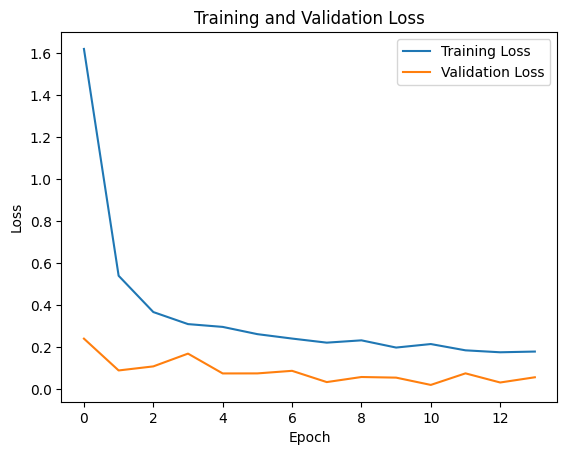

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

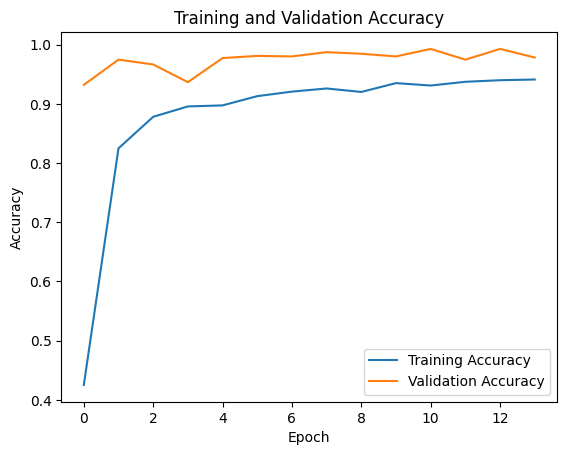

In [13]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### load the trained model and get the number of each 16 cc number

In [11]:
model3 = tf.keras.models.load_model('/content/drive/MyDrive/CV_Project2_OCR/detect-credit-number-v2')

In [12]:
def predict_cc_numbers(images):
  cc_number = ""
  for i in images:
    i = np.stack((i,)*3, axis=-1)
    i = np.expand_dims(i, axis=0)
    i = i.astype('float32') / 255.0
    y_pred = model3.predict(i)
    label = np.argmax(y_pred)
    cc_number = cc_number + str(label)
  return cc_number

In [ ]:
t = find_cc_numbers_place('/content/drive/MyDrive/CV_Project2_OCR/results/ss/img1.jpg')
print(predict_cc_numbers(t))

### template matching for detect credit or national card

In [29]:
# your code here #
def detect_card(path):
  logos = ['/content/drive/MyDrive/CV_Project2_OCR/logos/national-logo1.jpg',
                '/content/drive/MyDrive/CV_Project2_OCR/logos/national-logo2.jpg',
                '/content/drive/MyDrive/CV_Project2_OCR/logos/national-logo3.jpg',]

  in_card = cv2.imread(path)
  org_in_card = in_card.copy()

  in_card = cv2.fastNlMeansDenoising(in_card, h = 20)

  h_cc, w_cc = in_card.shape[0:2]
  prob_vals = []

  for i in (logos):
    logo = cv2.imread(i)
    logo = cv2.fastNlMeansDenoising(logo, h = 20)
    template_w, template_h, _ = logo.shape[::-1]
    res = cv2.matchTemplate(in_card, logo, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    # print(max_val)
    prob_vals.append(max_val)

  max_val = max(prob_vals)

  if max_val < 0.50:
    return "credit card"
  else:
    return "national card"

### read the national card number

In [44]:
def find_national_numbers(path):
  national_card = cv2.imread(path)
  national_card = cv2.resize(national_card, (600, 600))
  org_img = national_card.copy()

  national_card = cv2.fastNlMeansDenoising(national_card, h = 30)
  gray = cv2.cvtColor(national_card, cv2.COLOR_BGR2GRAY)

  gray = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11, 2)

  cropped_img = gray[130:210,300:480]

  cropped_img2 = cv2.bitwise_not(cropped_img)
  contours, _ = cv2.findContours(cropped_img2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv2.contourArea)
  contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

  cv2_imshow(cropped_img)

  cnt_num = 0
  national_digits = []
  for i, c in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(c)
    contourArea = cv2.contourArea(c)
    if contourArea > 20:
      roi = cropped_img[y:y + h, x:x + w]
      roi = cv2.resize(roi, (64,64), interpolation = cv2.INTER_AREA)
      national_digits.append(roi)
      cnt_num += 1
  return national_digits

In [ ]:
folders=["/content/drive/MyDrive/CV/OCR/pesian_numbers/33-zero",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/34-one",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/35-two",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/36-three",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/37-four",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/38-five",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/39-six",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/40-seven",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/41-eight",
         "/content/drive/MyDrive/CV/OCR/pesian_numbers/42-nine",]

x_train = np.empty((900, 64,64,3), dtype=np.uint8)
x_val = np.empty((100, 64,64,3), dtype=np.uint8)



cnt=0
for folder_path in folders:
  for root, dirs, files in os.walk(folder_path):
      for file in files:
          # Construct the absolute path of the file
          file_path = os.path.join(root, file)
          img=cv2.imread(file_path)
          img=cv2.resize(img, (64, 64))

          if cnt%10==0:
            x_val[int(cnt/10)]=img
          else:
            x_train[cnt-int(cnt/10)-1]=img
          print(cnt)
          cnt=cnt+1

In [ ]:
y_train = np.empty((900, 1), dtype=np.uint8)
y_val = np.empty((100, 1), dtype=np.uint8)

for i in range(900):
  y_train[i]=int(i/90)

for i in range(100):
  y_val[i]=int(i/10)

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

In [ ]:
randomZoom = tf.keras.Sequential([
  tf.keras.layers.RandomZoom(
      height_factor=(-0.25, -0.1),
      width_factor=None,
      fill_mode='reflect'
  )
])

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(64, 64, 3),
    include_top=False)

base_model.trainable=False

output_block3 = base_model.get_layer('conv3_block4_out').output

x = randomZoom(output_block3)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
output = tf.keras.layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(base_model.input, output)
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train,y_train, epochs=30, validation_data=(x_val, y_val))
model.save("presian_number_model.h5")

In [15]:
model_pesian_number = tf.keras.models.load_model("/content/drive/MyDrive/CV_Project2_OCR/presian_number_model.h5")

In [49]:
def predictPersianNumber(image):
  img=cv2.resize(image,(64,64))
  # img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  _, img = cv2.threshold(img, 60, 255, cv2.THRESH_BINARY)
  img=cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

  padding_size = 60
  padded_height = img.shape[0] + 2 * padding_size
  padded_width = img.shape[1] + 2 * padding_size
  padded_image = np.full((padded_height, padded_width,3),255, dtype=np.uint8)
  padded_image[padding_size:padding_size+img.shape[0], padding_size:padding_size+img.shape[1]] = img
  img=cv2.resize(padded_image,(64,64))
  img=np.expand_dims(img, axis=0)
  pred=model_pesian_number.predict(img)
  return pred

In [17]:
def predictNationalNumber(images):
    nationalNumber=""
    for image in images:
      pred=predictPersianNumber(image)
      max_index = np.argmax(pred)
      nationalNumber=nationalNumber+str(max_index)

    return nationalNumber

## transfer learning

In [ ]:
# your code here #

# part c - optional

In [ ]:
# your code here #